# Histogram sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ultraplot as uplt

import psdist as ps
import psdist.plot as psv

In [2]:
uplt.rc["cmap.discrete"] = False
uplt.rc["cmap.sequential"] = "viridis"
uplt.rc["figure.facecolor"] = "white"
uplt.rc["grid"] = False

Create distribution.

In [3]:
ndim = 6
size = 10_000
dims = ["x", "px", "y", "py", "z", "pz"]

rng = np.random.default_rng(1241)

cov_matrix = np.identity(ndim)
for i in range(ndim):
    for j in range(i):
        cov_matrix[i, j] = cov_matrix[j, i] = rng.uniform(-0.2, 0.2)

points = rng.multivariate_normal(np.zeros(ndim), cov_matrix, size=size)
for _ in range(4):
    scale = rng.uniform(0.5, 1.5, size=ndim)
    loc = rng.uniform(-3.0, 3.0, size=ndim)
    points_new = rng.normal(loc=loc, scale=scale, size=(size, ndim))
    points = np.vstack([points, points_new])
points -= np.mean(points, axis=0)

points_true = points.copy()

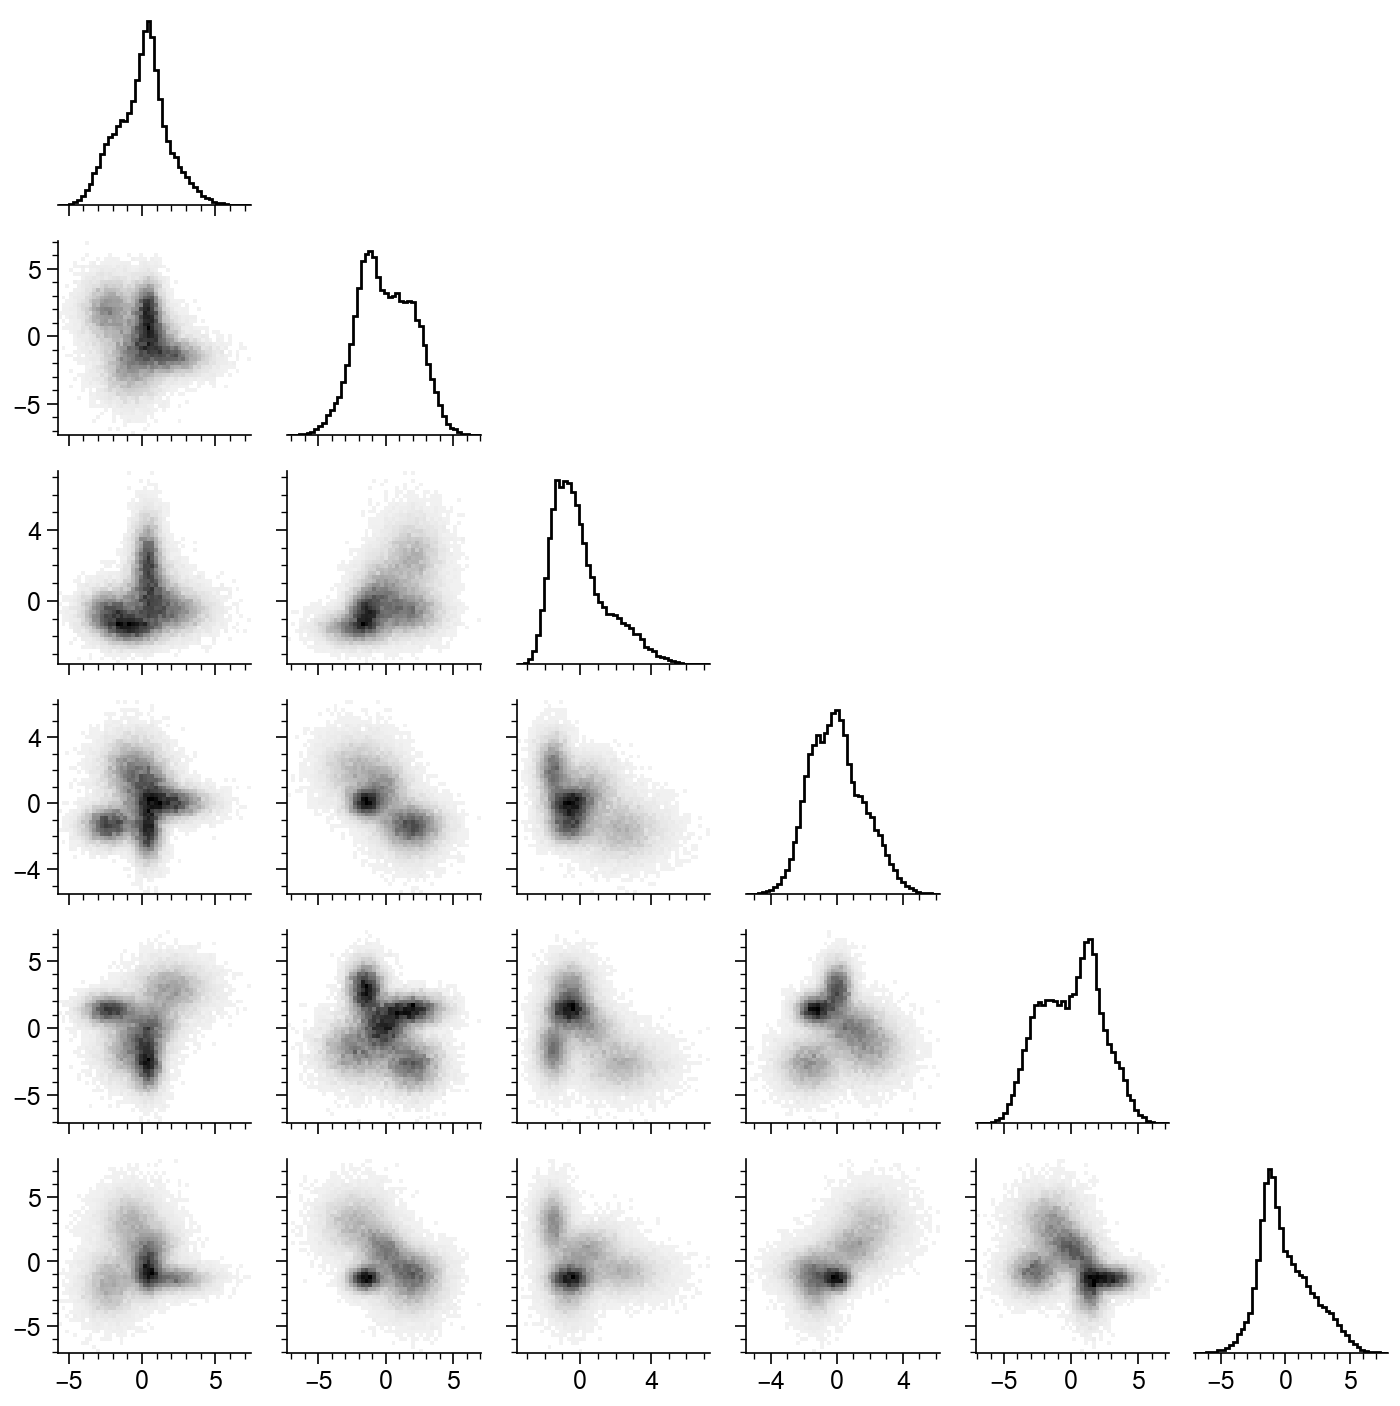

In [4]:
limits = ps.limits(points_true)

grid = psv.plot_corner(
    points_true,
    bins=50,
    limits=limits,
    grid_kws=dict(figwidth=7.0),
    cmap=uplt.Colormap("mono", left=0.05),
)
plt.show()

Compute histogram.

In [5]:
nbins = 11
hist = ps.histogram(points_true, bins=nbins, limits=limits)
print("hist.size =", hist.size)

hist.size = 1771561


Sample from histogram.

In [6]:
nsamp = 100_000
points_samp = hist.sample(size=nsamp)

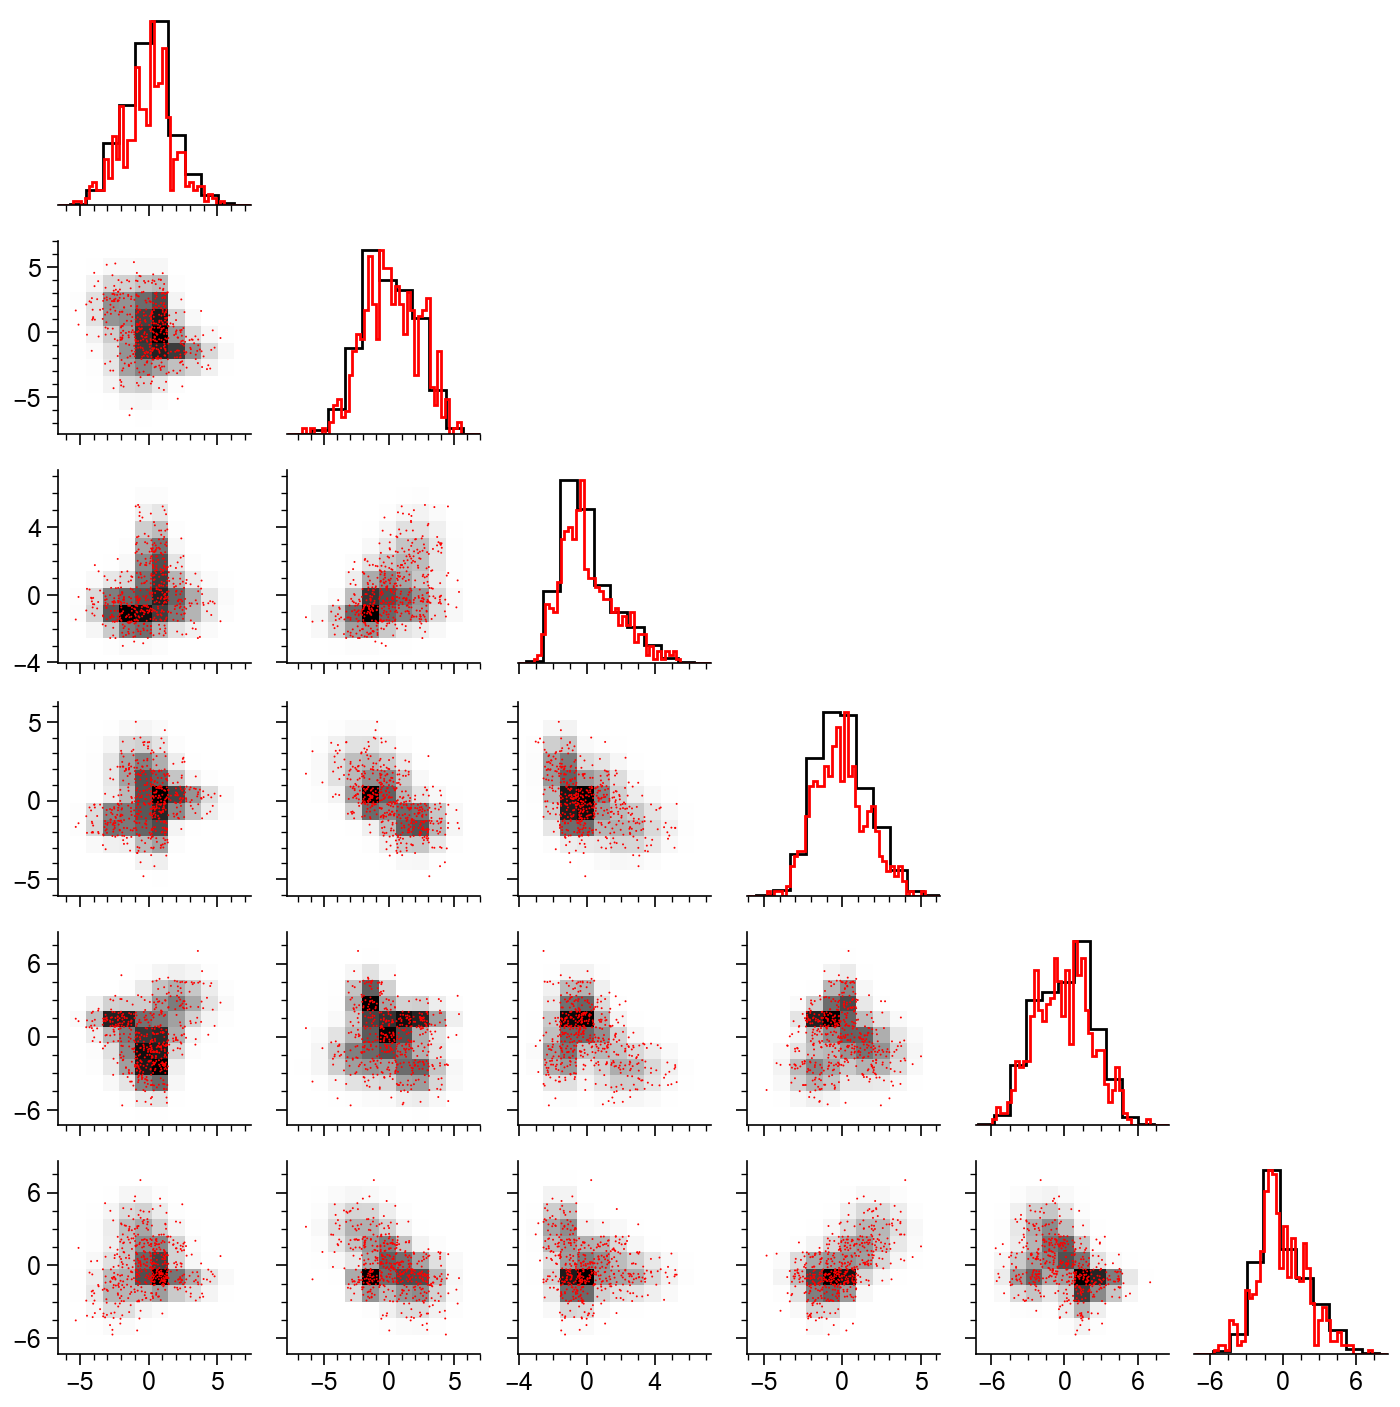

In [7]:
grid = psv.CornerGrid(ndim=6, figwidth=7.0)
grid.plot_hist(hist, cmap=uplt.Colormap("mono"))
grid.plot_points(
    points_samp[:500, :], kind="scatter", color="red", s=0.5, diag_kws=dict(color="red")
)

Compute sparse histogram.

In [8]:
hist_sparse = ps.sparse_histogram(points, bins=nbins, limits=limits)
print("sparse_hist.size =", hist_sparse.size)

sparse_hist.size = 12811


Sample from sparse histogram.

In [9]:
points_samp_sparse = hist_sparse.sample(nsamp)

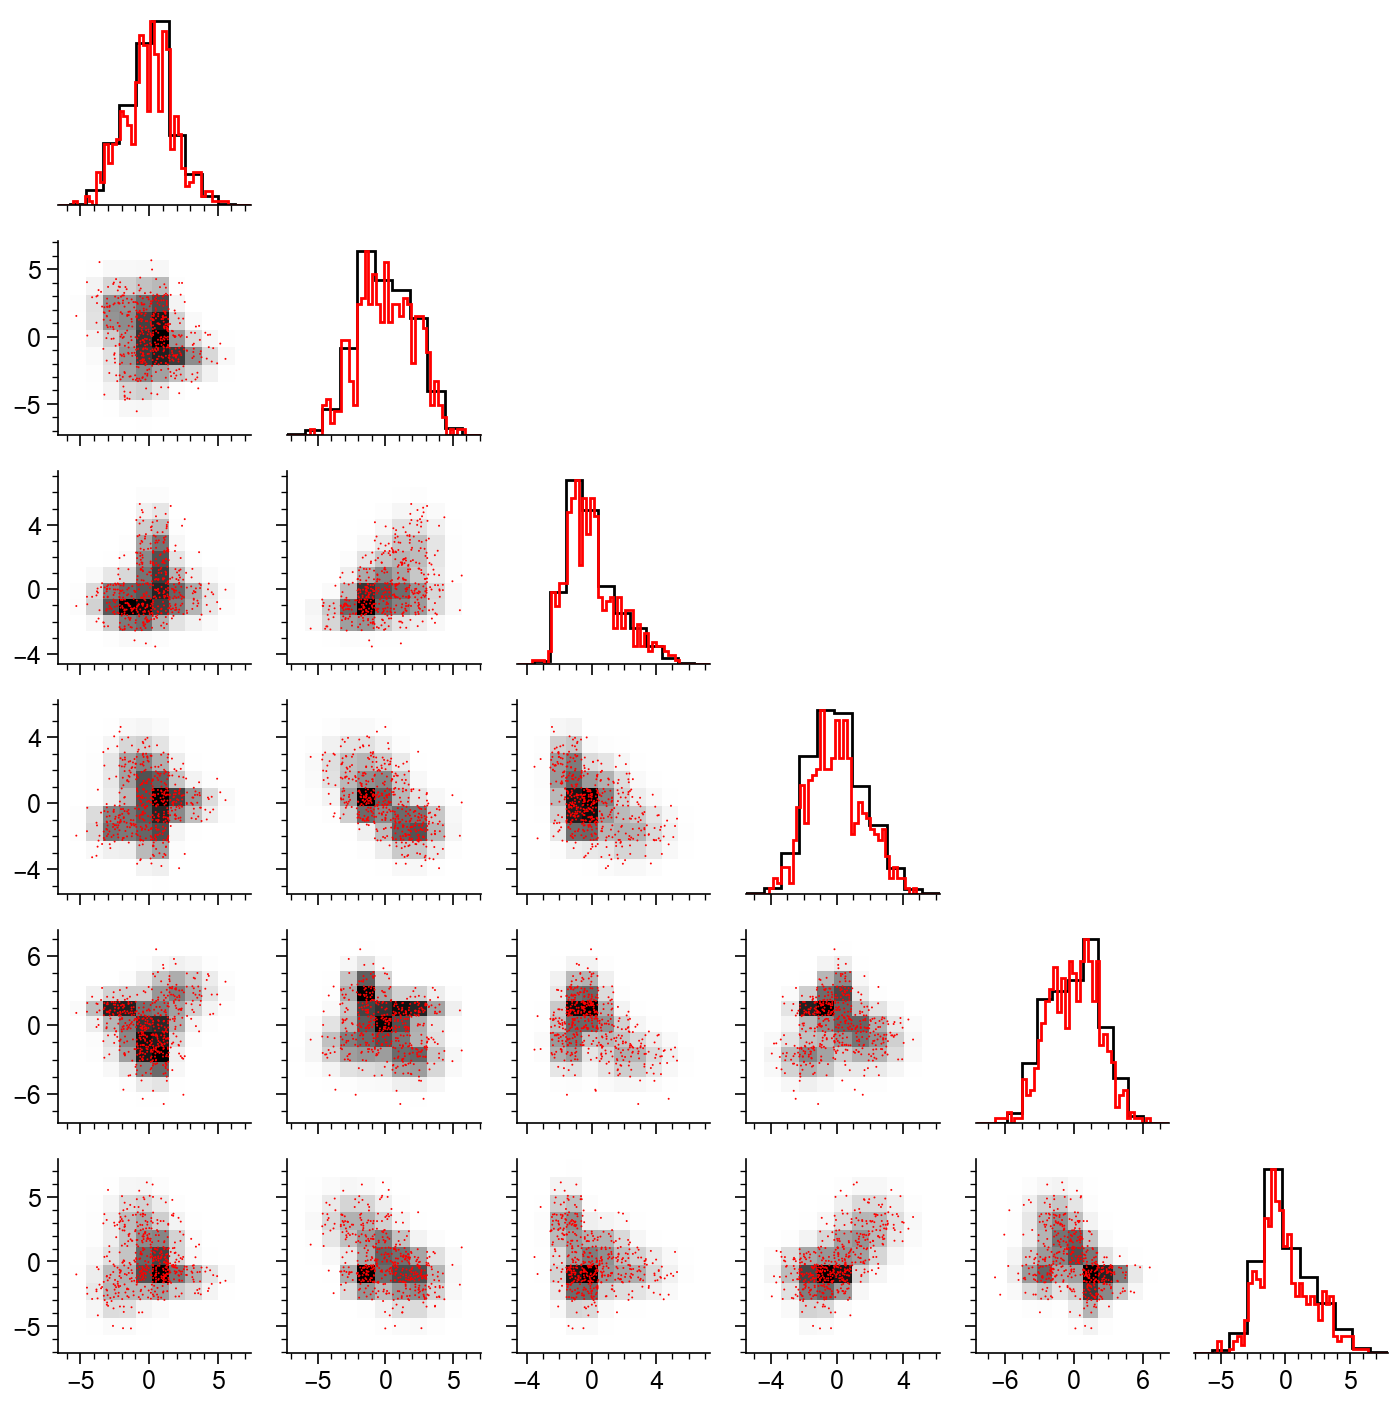

In [10]:
grid = psv.CornerGrid(ndim=6, figwidth=7.0)
grid.plot_hist(hist, cmap=uplt.Colormap("mono"))
grid.plot_points(
    points_samp_sparse[:500, :],
    kind="scatter",
    color="red",
    s=0.5,
    diag_kws=dict(color="red"),
)

Compare sparse and regular histogram samples.

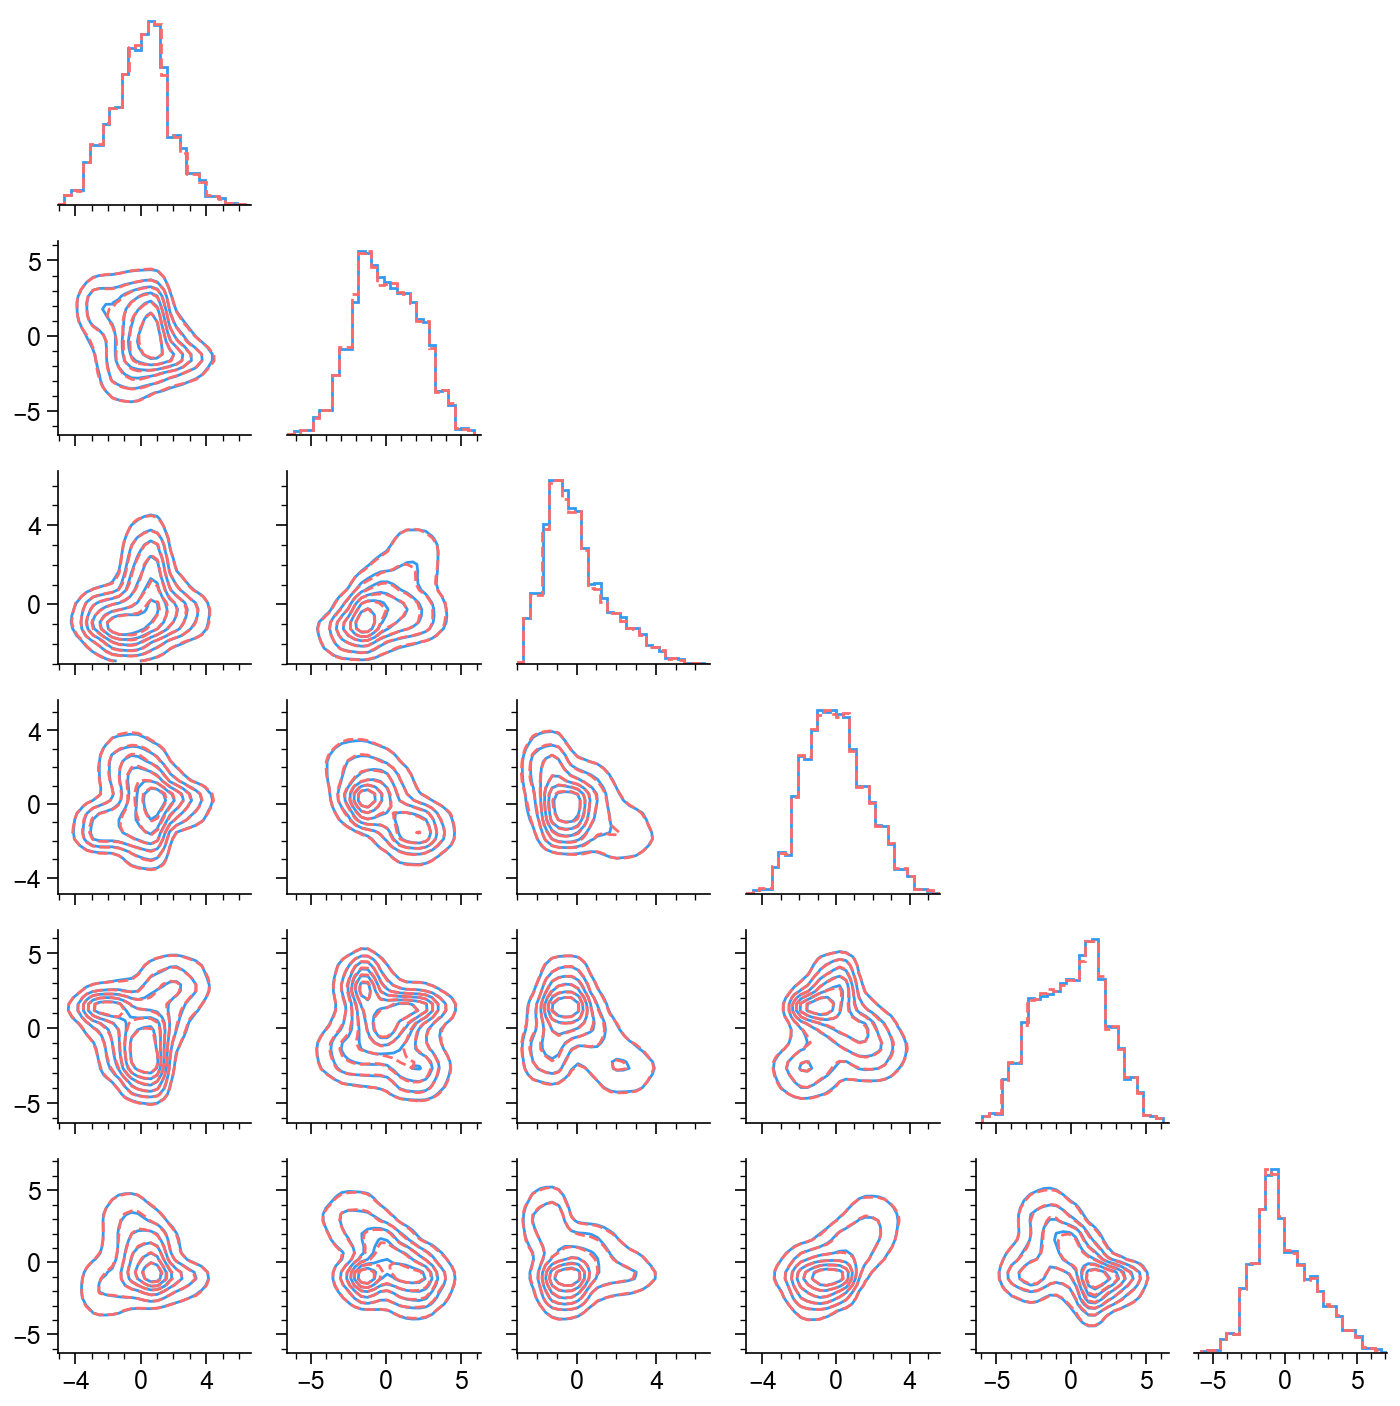

In [11]:
grid = psv.CornerGrid(ndim=6, figwidth=7.0)
for i, points in enumerate([points_samp, points_samp_sparse]):
    color = ["blue5", "red5"][i]
    ls = ["-", "--"][i]

    grid.plot_points(
        points,
        bins=30,
        autolim_kws=dict(pad=-0.10),
        kind="contour",
        process_kws=dict(scale="max", blur=1.0),
        diag_kws=dict(color=color, ls=ls),
        levels=np.linspace(0.0, 1.0, 7, endpoint=False)[1:],
        colors=color,
        lw=1.0,
        ls=ls,
    )